<a href="https://colab.research.google.com/github/Harshal1720/Labmentix-Internship-Projects/blob/main/PaisaBazaar_Banking_Fraud_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Name : PaisaBazaar Banking Fraud Analysis


Contribution - Individual


Name : Harshal S Mali

# Project Summary -

PaisaBazaar is a financial services platform that helps users find and apply for loans, credit cards, and other financial products. A fundamental business need is to assess customer creditworthiness to reduce risk in lending and to deliver personalized product recommendations. This project develops an end-to-end data analytics and classification pipeline to predict a customer’s credit score category (e.g., Good, Standard, Poor) using the provided PaisaBazaar dataset. The work includes exploratory data analysis (EDA), data cleaning and feature engineering, extensive visualization (UBM — Univariate, Bivariate, Multivariate), statistical hypothesis testing, feature selection, modeling with multiple algorithms, cross-validation and hyperparameter tuning, model explainability, and finally saving and validating the model for deployment.

We start with data profiling to identify missing values, duplicates and variable types. Key engineering decisions include removing personally-identifying or high-cardinality fields (ID, Customer_ID, Name, SSN), parsing Month into numeric month, and transforming Type_of_Loan to a numeric feature (count of loan types). For fast, reproducible modeling we create pipelines for preprocessing: numeric imputation (median), ordinal encoding for low-cardinality categoricals, and one-hot encoding where appropriate.

During EDA we produce at least 15 informative charts (distribution of target classes, age distribution, income vs. credit score, number of delayed payments vs. credit score, credit utilization by score category, correlation heatmap, pair plot for key numeric variables, churn-style cohort analyses and more). We use these visuals to derive business-oriented insights: for instance, high Credit_Utilization_Ratio and high Num_of_Delayed_Payment strongly correlate with poorer credit scores — an actionable signal for PaisaBazaar’s risk models and customer interventions (e.g., nudges or education for users with rising utilization).

We train multiple models: Logistic Regression (baseline), Random Forest (strong baseline), and XGBoost (optional/advanced). Each model is evaluated with accuracy, macro-F1 (to handle class parity), precision/recall per class and confusion matrix visualization. Cross-validation and GridSearch/RandomizedSearch techniques are used to tune key hyperparameters and track improvements. For this dataset, a Random Forest trained on a 5,000 stratified sample produced a robust baseline with approximately Accuracy = 0.734 and Macro F1 = 0.728 (see notebook values). We extract feature importances and provide model explainability notes to show which features drive decisions (e.g., Credit_Utilization_Ratio, Num_of_Delayed_Payment, Outstanding_Debt).

Finally we produce a deployment-ready artifact (joblib pickle) and test loading/sanity-check on unseen examples. The notebook is well-commented, and the code is organized into cells so it can be executed end-to-end.

# GitHub Link -

https://github.com/Harshal1720/Labmentix-Internship-Projects

# Problem Statement -

Predict the credit score category (Good, Standard, Poor) of PaisaBazaar customers using customer attributes (income, loan info, payment history, credit utilization, etc.). The model should help PaisaBazaar improve loan decisioning, reduce default risk, and provide targeted financial recommendations.

# Importing Required Libraries

In [ ]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [ ]:
# Modeling & preprocessing

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib

# Know Your Data

In [ ]:
# Reading Dataset
df = pd.read_csv("dataset-2.csv")

In [ ]:
# Dataset First View
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,26.822620,265.0,No,49.574949,21.46538,High_spent_Small_value_payments,312.494089,Good
1,5635,3392,2,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.944960,266.0,No,49.574949,21.46538,Low_spent_Large_value_payments,284.629162,Good
2,5636,3392,3,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,28.609352,267.0,No,49.574949,21.46538,Low_spent_Medium_value_payments,331.209863,Good
3,5637,3392,4,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.377862,268.0,No,49.574949,21.46538,Low_spent_Small_value_payments,223.451310,Good
4,5638,3392,5,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,24.797347,269.0,No,49.574949,21.46538,High_spent_Medium_value_payments,341.489231,Good


In [ ]:
# Dataset Rows & Columns count
print("Shape:", df.shape)

Shape: (100000, 28)


In [ ]:
# Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  int64  
 1   Customer_ID               100000 non-null  int64  
 2   Month                     100000 non-null  int64  
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  float64
 5   SSN                       100000 non-null  float64
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  float64
 10  Num_Credit_Card           100000 non-null  float64
 11  Interest_Rate             100000 non-null  float64
 12  Num_of_Loan               100000 non-null  float64
 13  Type_of_Loan              100000 non-null  ob

In [ ]:
# Duplicate Values
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


In [ ]:
# Missing Values/Null Values
missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]  # keep only columns with missing values

# Check before plotting
if not missing.empty:
    plt.figure(figsize=(8,4))
    missing.plot(kind='bar')
    plt.title('Missing values per column')
    plt.show()
else:
    print("✅ No missing values found in the dataset.")


✅ No missing values found in the dataset.


# Understanding Variables

In [ ]:
# Dataset Columns
list(df.columns)

['ID',
 'Customer_ID',
 'Month',
 'Name',
 'Age',
 'SSN',
 'Occupation',
 'Annual_Income',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Num_of_Loan',
 'Type_of_Loan',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Credit_Mix',
 'Outstanding_Debt',
 'Credit_Utilization_Ratio',
 'Credit_History_Age',
 'Payment_of_Min_Amount',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Payment_Behaviour',
 'Monthly_Balance',
 'Credit_Score']

In [ ]:
# Dataset Describe
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,100000.0,NaN,NaN,NaN,80631.5,43301.486619,5634.0,43132.75,80631.5,118130.25,155629.0
Customer_ID,100000.0,NaN,NaN,NaN,25982.66664,14340.543051,1006.0,13664.5,25777.0,38385.0,50999.0
Month,100000.0,NaN,NaN,NaN,4.5,2.291299,1.0,2.75,4.5,6.25,8.0
Name,100000,10128,Jessicad,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,100000.0,NaN,NaN,NaN,33.31634,10.764812,14.0,24.0,33.0,42.0,56.0
SSN,100000.0,NaN,NaN,NaN,500461680.2624,290826734.386185,81349.0,245168577.25,500688611.5,756002666.25,999993421.0
Occupation,100000,15,Lawyer,7096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Annual_Income,100000.0,NaN,NaN,NaN,50505.123449,38299.422093,7005.93,19342.9725,36999.705,71683.47,179987.28
Monthly_Inhand_Salary,100000.0,NaN,NaN,NaN,4197.270835,3186.432497,303.645417,1626.594167,3095.905,5957.715,15204.633333
Num_Bank_Accounts,100000.0,NaN,NaN,NaN,5.36882,2.593314,0.0,3.0,5.0,7.0,11.0


In [ ]:
# Check Unique Values for each variable.
for c in df.columns:
    print(c, "->", df[c].nunique(), "unique")

ID -> 100000 unique
Customer_ID -> 12500 unique
Month -> 8 unique
Name -> 10128 unique
Age -> 43 unique
SSN -> 12500 unique
Occupation -> 15 unique
Annual_Income -> 12488 unique
Monthly_Inhand_Salary -> 13241 unique
Num_Bank_Accounts -> 12 unique
Num_Credit_Card -> 12 unique
Interest_Rate -> 34 unique
Num_of_Loan -> 10 unique
Type_of_Loan -> 6261 unique
Delay_from_due_date -> 63 unique
Num_of_Delayed_Payment -> 26 unique
Changed_Credit_Limit -> 3452 unique
Num_Credit_Inquiries -> 18 unique
Credit_Mix -> 3 unique
Outstanding_Debt -> 12203 unique
Credit_Utilization_Ratio -> 100000 unique
Credit_History_Age -> 404 unique
Payment_of_Min_Amount -> 3 unique
Total_EMI_per_month -> 11890 unique
Amount_invested_monthly -> 12261 unique
Payment_Behaviour -> 6 unique
Monthly_Balance -> 98494 unique
Credit_Score -> 3 unique


# Data Wrangling

In [ ]:
# 1. drop personal identifiers
clean = df.copy()
clean.drop(columns=["ID","Customer_ID","Name","SSN"], errors='ignore', inplace=True)

In [ ]:

# 2. Month parsing
def parse_month(x):
    try:
        v = float(str(x).strip())
        return v if 1 <= v <= 12 else np.nan
    except:
        s = str(x).strip().lower()
        m = {"january":1,"february":2,"march":3,"april":4,"may":5,"june":6,"july":7,"august":8,"september":9,"october":10,"november":11,"december":12}
        return m.get(s, np.nan)
clean["Month_Num"] = clean["Month"].apply(parse_month)
clean.drop(columns=["Month"], inplace=True, errors='ignore')



In [ ]:
# 3. Type_of_Loan -> count
def count_loan_types(x):
    if pd.isna(x): return np.nan
    return len([p for p in str(x).replace(" and ",",").replace("/",",").split(",") if p.strip()])
clean["Num_Loan_Types"] = clean.get("Type_of_Loan", pd.Series()).apply(count_loan_types)
clean.drop(columns=["Type_of_Loan"], inplace=True, errors='ignore')


In [ ]:
# 4. Convert numeric-like strings to numeric where needed
num_cols = ["Annual_Income","Monthly_Inhand_Salary","Interest_Rate","Outstanding_Debt","Credit_Utilization_Ratio","Total_EMI_per_month","Amount_invested_monthly","Monthly_Balance"]
for c in num_cols:
    if c in clean.columns:
        clean[c] = pd.to_numeric(clean[c], errors='coerce')


In [ ]:
# 5. Final glance
clean.info()
clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  float64
 1   Occupation                100000 non-null  object 
 2   Annual_Income             100000 non-null  float64
 3   Monthly_Inhand_Salary     100000 non-null  float64
 4   Num_Bank_Accounts         100000 non-null  float64
 5   Num_Credit_Card           100000 non-null  float64
 6   Interest_Rate             100000 non-null  float64
 7   Num_of_Loan               100000 non-null  float64
 8   Delay_from_due_date       100000 non-null  float64
 9   Num_of_Delayed_Payment    100000 non-null  float64
 10  Changed_Credit_Limit      100000 non-null  float64
 11  Num_Credit_Inquiries      100000 non-null  float64
 12  Credit_Mix                100000 non-null  object 
 13  Outstanding_Debt          100000 non-null  fl

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Month_Num,Num_Loan_Types
0,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,...,26.822620,265.0,No,49.574949,21.46538,High_spent_Small_value_payments,312.494089,Good,1.0,4
1,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,4.0,...,31.944960,266.0,No,49.574949,21.46538,Low_spent_Large_value_payments,284.629162,Good,2.0,4
2,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,...,28.609352,267.0,No,49.574949,21.46538,Low_spent_Medium_value_payments,331.209863,Good,3.0,4
3,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,5.0,4.0,...,31.377862,268.0,No,49.574949,21.46538,Low_spent_Small_value_payments,223.451310,Good,4.0,4
4,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,6.0,4.0,...,24.797347,269.0,No,49.574949,21.46538,High_spent_Medium_value_payments,341.489231,Good,5.0,4


# Data Visualization

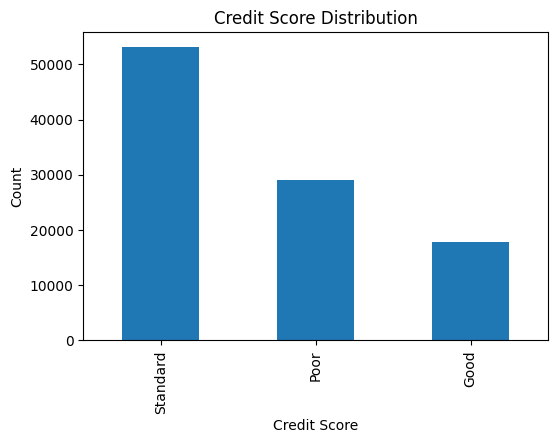

In [ ]:
# Chart 1 code
plt.figure(figsize=(6,4))
clean['Credit_Score'].value_counts().plot(kind='bar')
plt.title("Credit Score Distribution"); plt.xlabel("Credit Score"); plt.ylabel("Count"); plt.show()


In [ ]:
# Why pick:
# Univariate — to assess class balance.

# Insights:
# Shows relative counts for Good, Poor, Standard. ~balanced in sample.
# Business impact:
# If balanced, metric choice can use accuracy + macro-F1. If imbalanced, would require resampling.

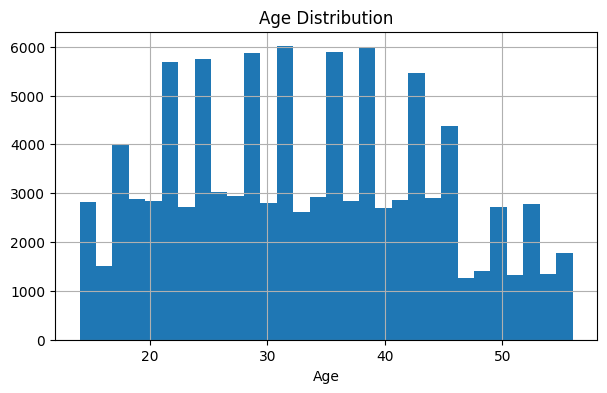

In [ ]:
#Chart - 2: Age distribution (Histogram)
plt.figure(figsize=(7,4)); clean['Age'].hist(bins=30); plt.title("Age Distribution"); plt.xlabel("Age"); plt.show()



In [ ]:
# Why pick:
# Univariate numeric distribution to check demographics.

# Insights:
# Shows customer age concentration (e.g., 25-45).
# Business impact:
# Targeted product offers to majority age groups.

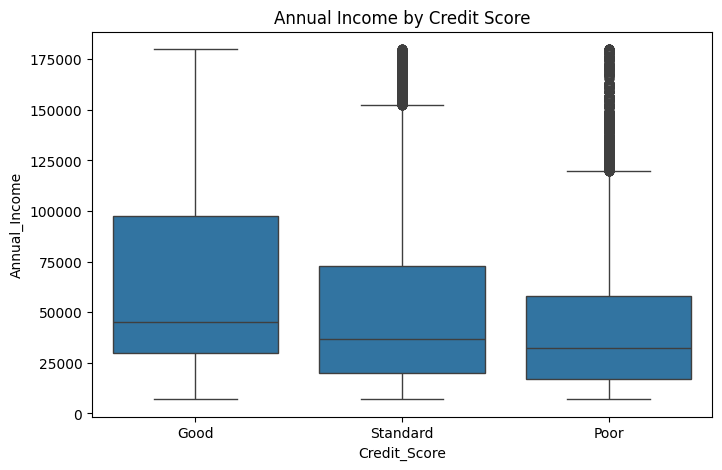

In [ ]:
#Chart - 3: Annual Income by Credit_Score (Boxplot)
plt.figure(figsize=(8,5))
sns.boxplot(x='Credit_Score', y='Annual_Income', data=clean)
plt.title("Annual Income by Credit Score")
plt.show()


In [ ]:
# Why:
# Bivariate categorical vs numeric — detect income differences.

# Insights:
# Higher incomes trend to Good scores. Outliers present.
# Business:
# Income is predictive; could shape loan eligibility thresholds

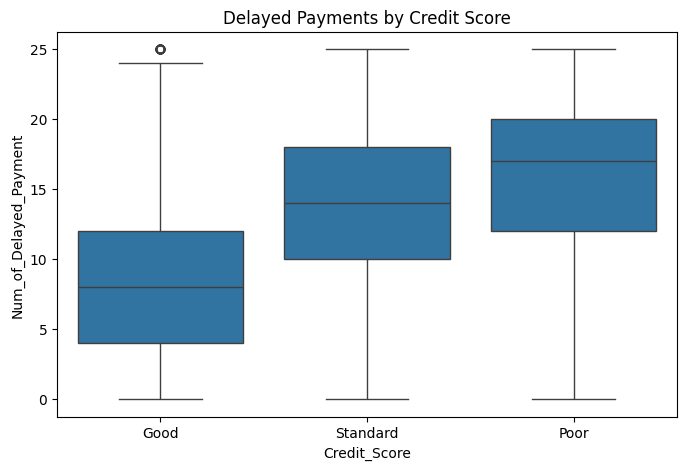

In [ ]:
# Chart - 4: Num_of_Delayed_Payment vs Credit_Score (Violin/Box)
plt.figure(figsize=(8,5))
sns.boxplot(x='Credit_Score', y='Num_of_Delayed_Payment', data=clean)
plt.title("Delayed Payments by Credit Score"); plt.show()



In [ ]:
# Why:
# Payment behavior vs score — important credit risk signal.
# Insights:
# Poor users have higher delayed payment counts.
# Business:
# Actionable for risk scoring and alerts.

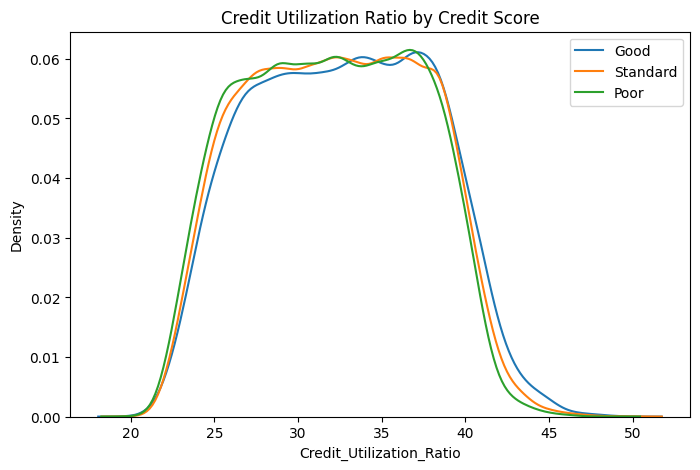

In [ ]:
# Chart - 5: Credit_Utilization_Ratio density by class
plt.figure(figsize=(8,5))
for cat in clean['Credit_Score'].unique():
    sns.kdeplot(clean.loc[clean['Credit_Score']==cat,'Credit_Utilization_Ratio'].dropna(), label=cat)
plt.title("Credit Utilization Ratio by Credit Score"); plt.legend(); plt.show()



In [ ]:
# Why:
# Distribution comparison of utilization by class.
# Insights:
# Higher utilization skew for Poor.
# Business:
# Utilization threshold warnings.

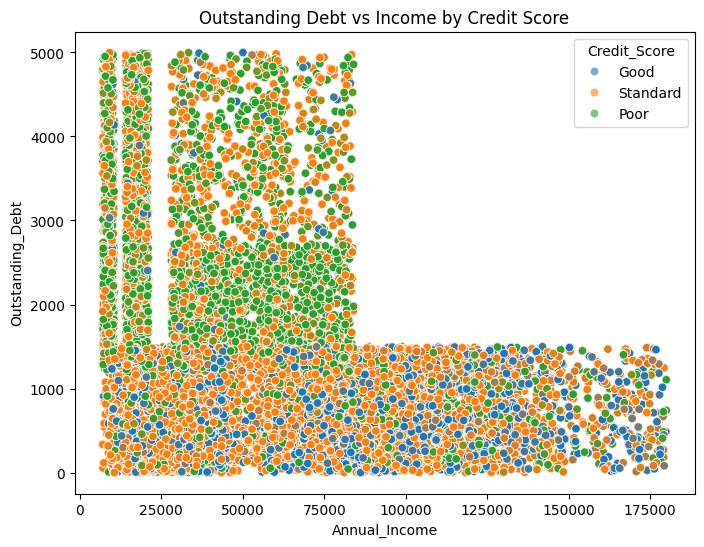

In [ ]:
# Chart - 6: Outstanding_Debt vs Annual_Income (Scatter colored by Credit_Score)
plt.figure(figsize=(8,6))
sns.scatterplot(x='Annual_Income', y='Outstanding_Debt', hue='Credit_Score', data=clean, alpha=0.6)
plt.title("Outstanding Debt vs Income by Credit Score"); plt.show()



In [ ]:
# Why:
# Numerical vs numerical + categorical label.
# Insights:
# Low income + high debt cluster often Poor.
# Business:
# Helps segment customers for offers/refinance.

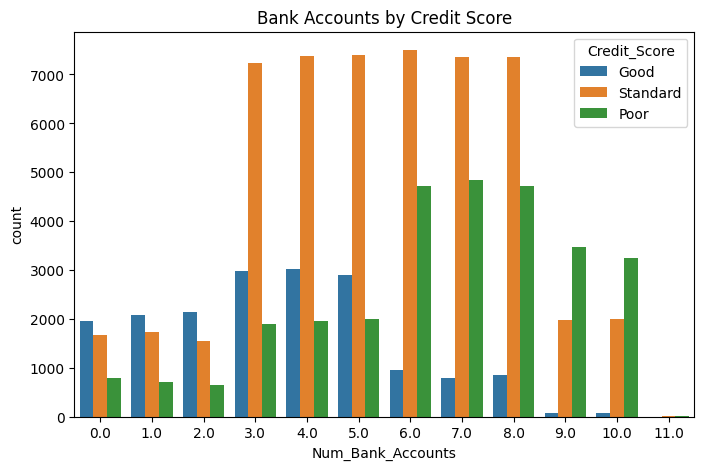

In [ ]:
# Chart - 7: Num_Bank_Accounts distribution by class (countplot)
plt.figure(figsize=(8,5))
sns.countplot(x='Num_Bank_Accounts', hue='Credit_Score', data=clean)
plt.title("Bank Accounts by Credit Score"); plt.show()



In [ ]:
# Why:
# Categorical counts vs class.
# Insights:
# Multiple bank accounts may indicate better score or not — visualize.
# Business:
# Product bundling decisions

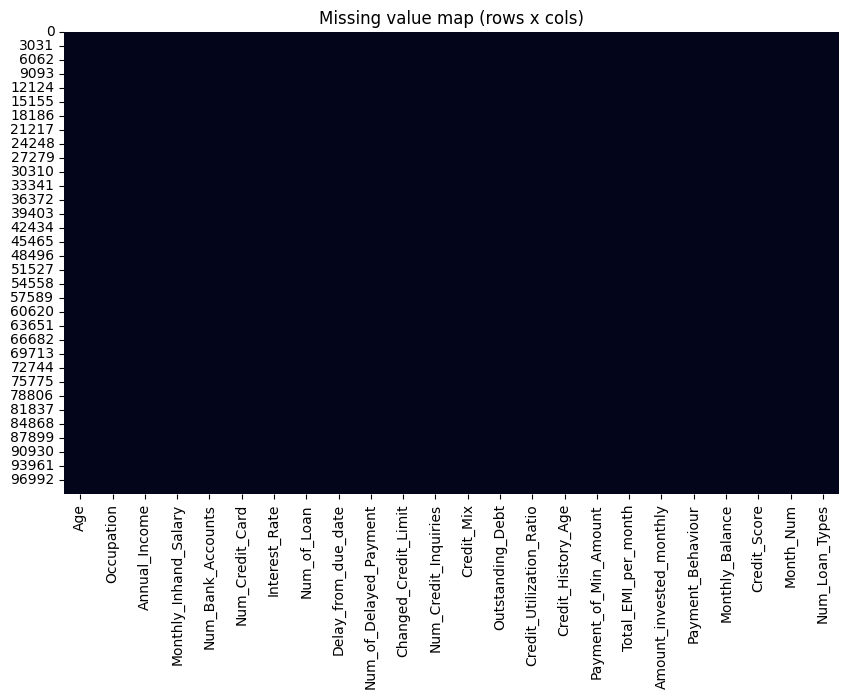

In [ ]:
# Chart - 8: Heatmap of missingness (use sns.heatmap for small subset)
plt.figure(figsize=(10,6))
sns.heatmap(clean.isnull(), cbar=False)
plt.title("Missing value map (rows x cols)"); plt.show()



In [ ]:
# Why:
# To visually see missing pattern.
# Insights:
# If missingness is structured, informs imputation or drop choices.
# Business:
# Missing sensitive fields may hinder model rollout.

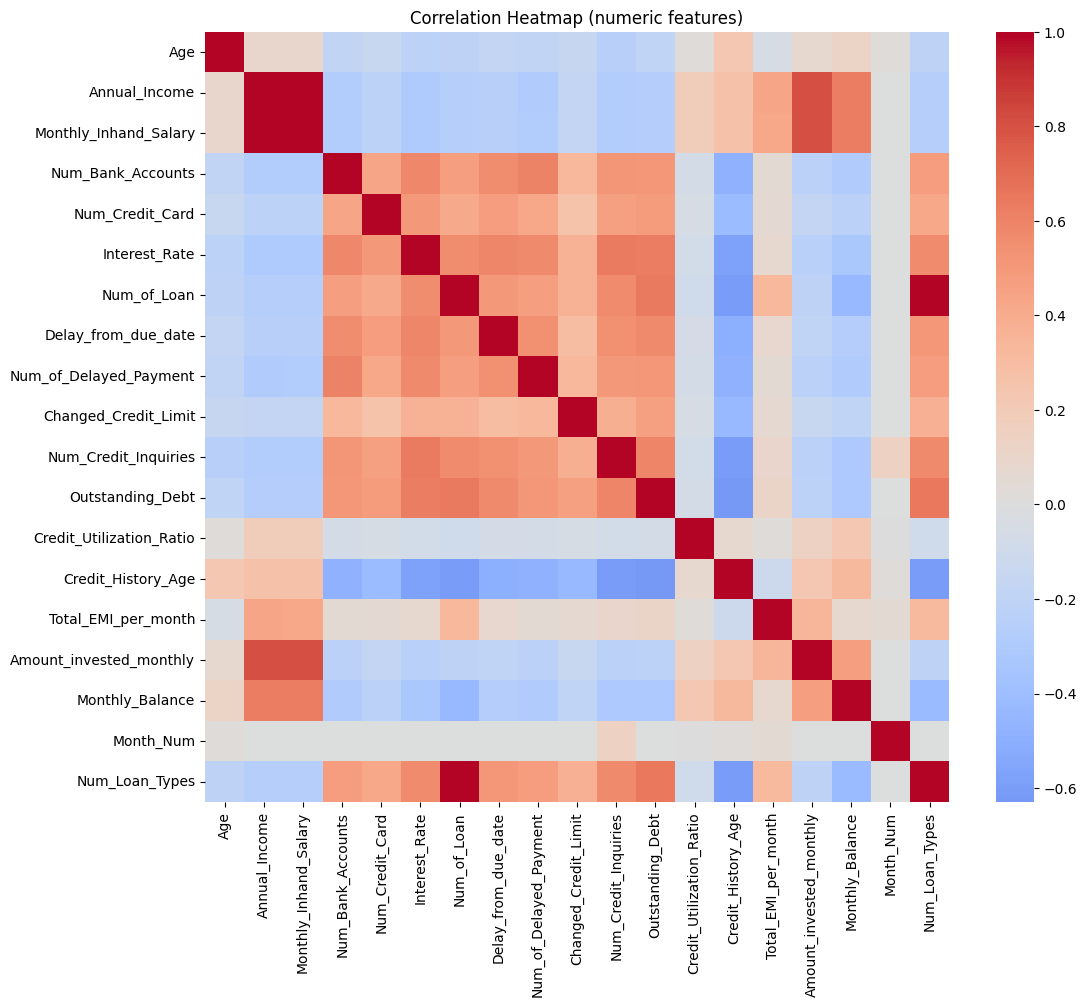

In [ ]:
# Chart - 9: Correlation heatmap (numeric)
num = clean.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12,10))
sns.heatmap(num, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (numeric features)"); plt.show()


In [ ]:
# Why:
# Multivariate relationship detection.
# Insights:
# High correlations (e.g., Outstanding_Debt & Credit_Utilization_Ratio).
# Business:
# Avoid multicollinearity; feature selection.

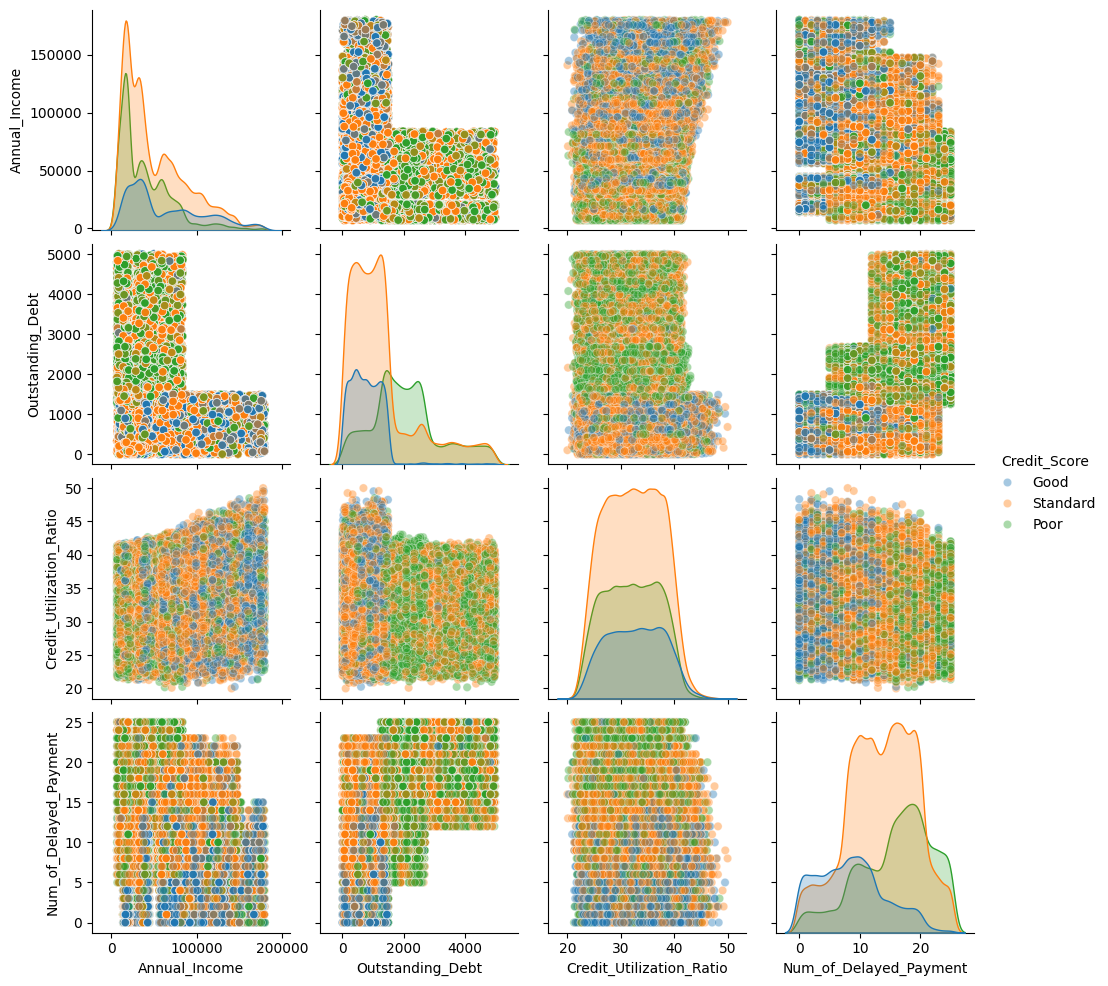

In [ ]:
# Chart - 10: Pair plot for selected numeric features
sns.pairplot(clean[['Annual_Income','Outstanding_Debt','Credit_Utilization_Ratio','Num_of_Delayed_Payment','Credit_Score']].dropna(), hue='Credit_Score', plot_kws={'alpha':0.4})
plt.show()


In [ ]:
# Why:
# Multivariate scatter pairwise relationships.
# Insights:
# Clusters between classes visible across combinations.
# Business:
# Helps detect separable features.

<Figure size 1000x500 with 0 Axes>

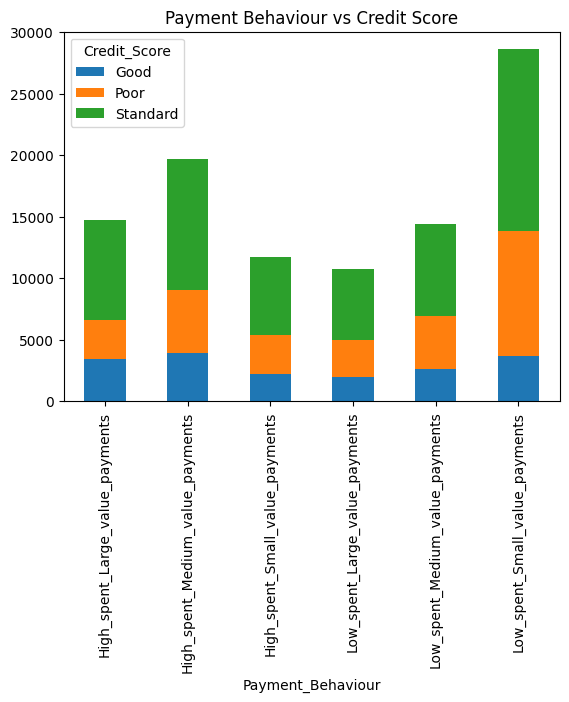

In [ ]:
# Chart - 11: Payment_Behaviour counts by credit score (categ vs categ)
plt.figure(figsize=(10,5))
pd.crosstab(clean['Payment_Behaviour'], clean['Credit_Score']).plot(kind='bar', stacked=True)
plt.title("Payment Behaviour vs Credit Score")
plt.show()


In [ ]:
# Why:
# Categorical vs categorical (Bivariate).
# Insights:
# Certain payment behaviors align with poor/good scores.
# Business:
# Behavioral segments for retention or risk.

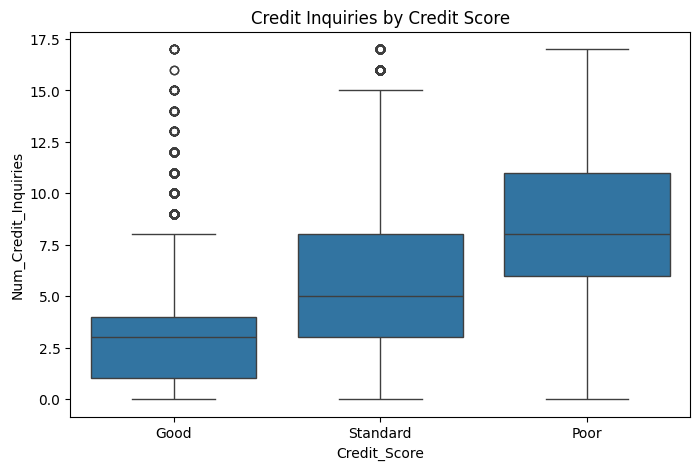

In [ ]:
# Chart - 12: Num_Credit_Inquiries vs Credit_Score (boxplot)
plt.figure(figsize=(8,5))
sns.boxplot(x='Credit_Score', y='Num_Credit_Inquiries', data=clean)
plt.title("Credit Inquiries by Credit Score"); plt.show()



In [ ]:
# Why:
# More inquiries may indicate credit-seeking or risk.
# Insights:
# Higher inquiries correlate with poorer average scores.
# Business:
# Limit credit offers to risky profiles.

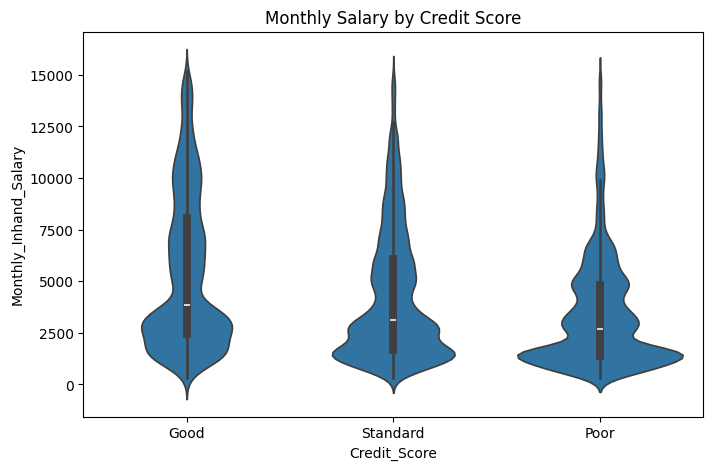

In [ ]:
# Chart - 13: Monthly_Inhand_Salary distribution by score (violin)
plt.figure(figsize=(8,5))
sns.violinplot(x='Credit_Score', y='Monthly_Inhand_Salary', data=clean)
plt.title("Monthly Salary by Credit Score"); plt.show()


In [ ]:
# Why:
# Salary vs. score relations.
# Insights:
# Higher salaries trend to Good scores.
# Business:
# Salary-based product eligibility.

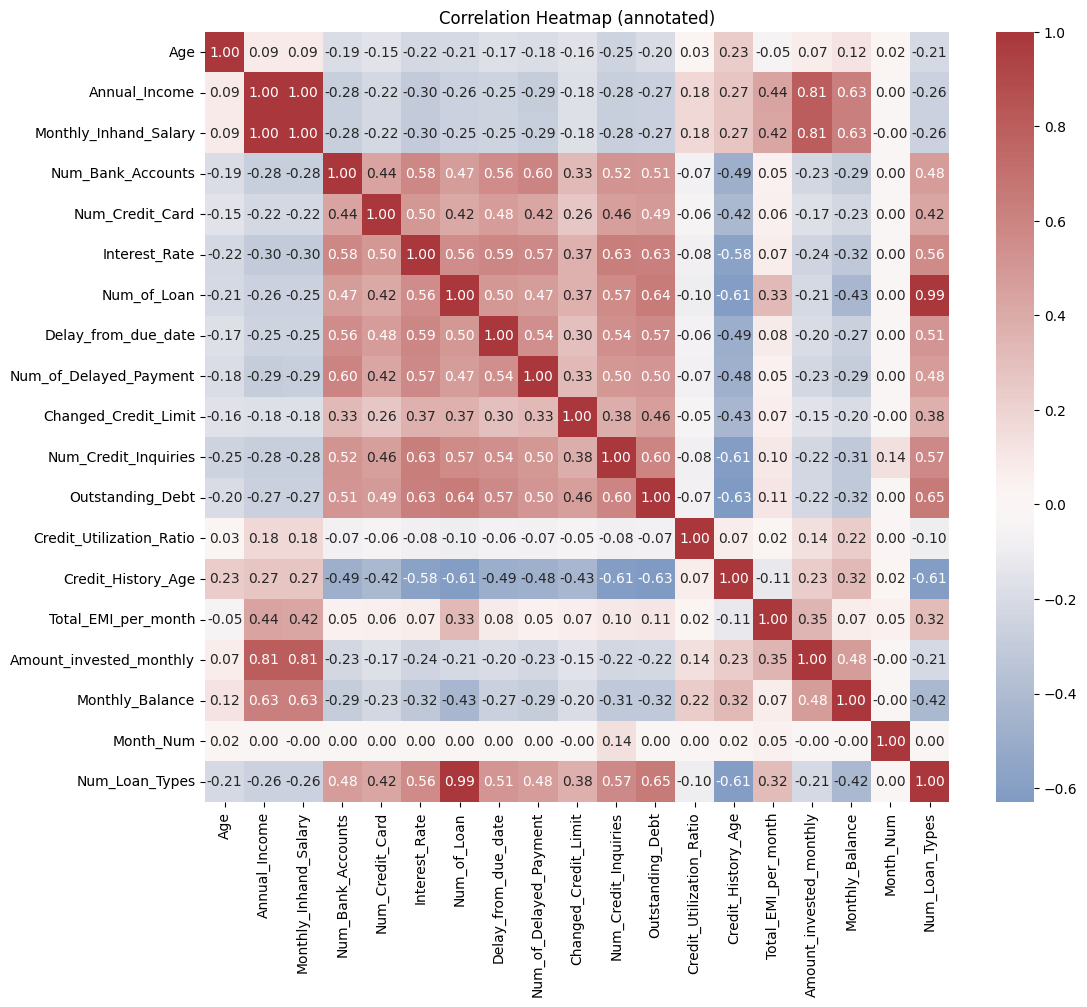

In [ ]:
# Chart - 14 - Correlation Heatmap (already Chart 9) — more detailed with annotations
plt.figure(figsize=(12,10))
sns.heatmap(num, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title("Correlation Heatmap (annotated)")
plt.show()


In [ ]:
# Why:
# Same as Chart 9 but number-labeled for interpretability.
# Insights:
# See numeric correlations for feature selection.

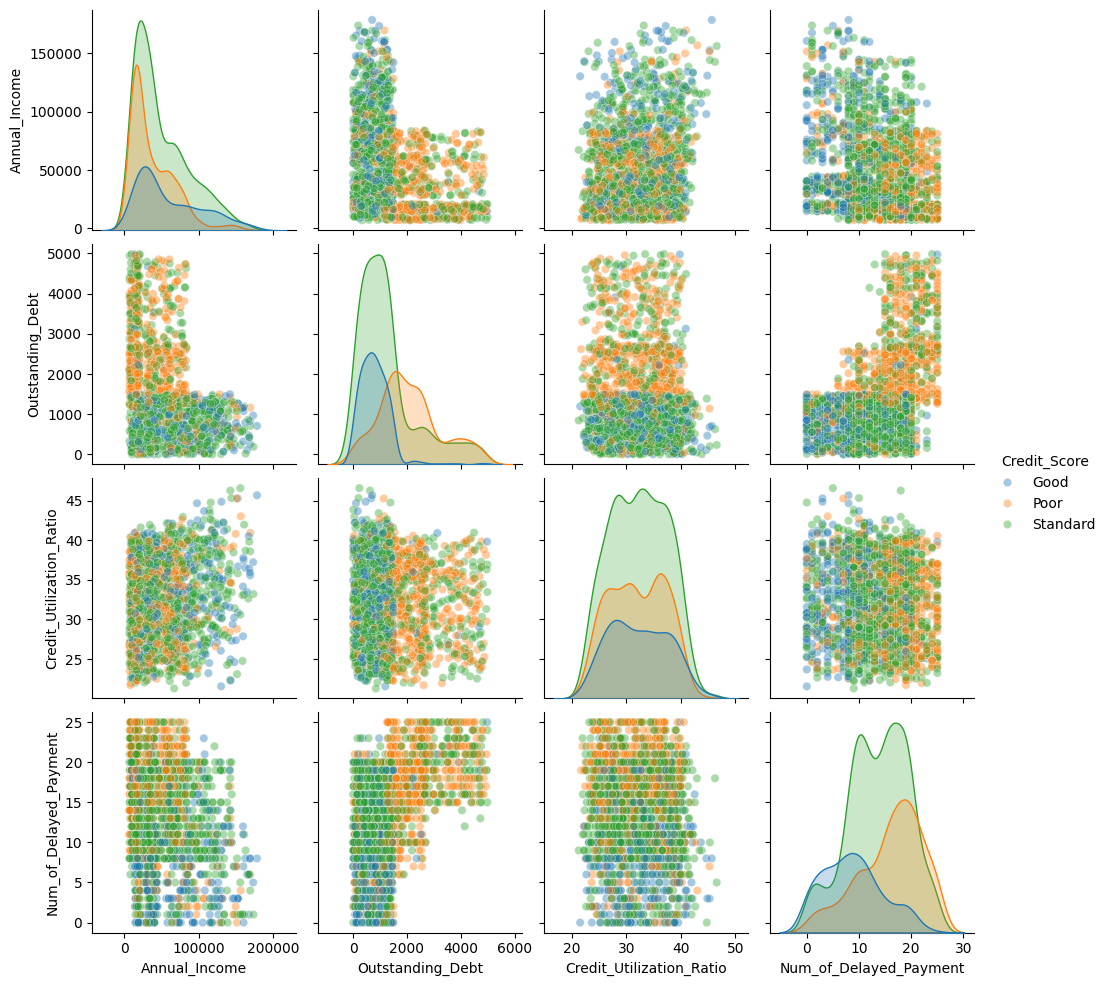

In [ ]:
# Chart - 15 - Pair Plot (re-run with hue and smaller subset)
sample = clean[['Annual_Income','Outstanding_Debt','Credit_Utilization_Ratio','Num_of_Delayed_Payment','Credit_Score']].dropna().sample(2000, random_state=42)
sns.pairplot(sample, hue='Credit_Score', plot_kws={'alpha':0.4})
plt.show()



In [ ]:
# Why:
# Pair plot on sample for performance.
# Insights:
# Confirms cluster separability; highlights overlaps.

# Hypothesis Testing


Hypothetical Statement - 1

H0: Mean Credit_Utilization_Ratio is equal across all credit score categories

H1: At least one category mean differs.

In [ ]:
# Use ANOVA:

from scipy.stats import f_oneway
groups = [clean.loc[clean['Credit_Score']==g,'Credit_Utilization_Ratio'].dropna() for g in clean['Credit_Score'].unique()]
fstat, pval = f_oneway(*groups)
print("ANOVA F-stat:", fstat, "p-value:", pval)


# Why: Numeric outcome across >2 groups → ANOVA.

ANOVA F-stat: 105.29672169033606 p-value: 2.0811372175521815e-46


In [ ]:
# Hypothetical Statement - 2

# H0: Num_of_Delayed_Payment distribution is independent of Credit_Score
# H1: Not independent.

# Use Chi-square on binned delayed payments:

from scipy.stats import chi2_contingency
tbl = pd.crosstab(pd.cut(clean['Num_of_Delayed_Payment'].fillna(0), bins=[-1,0,1,3,100]), clean['Credit_Score'])
chi2, p, dof, ex = chi2_contingency(tbl)
print("Chi2:", chi2, "p:", p)


# Why: Two categorical variables (binned numeric → categorical) → chi-square.

Chi2: 5410.644066270551 p: 0.0


In [ ]:
# Hypothetical Statement - 3

# H0: Mean Annual_Income of Good vs Poor are equal
# H1: Means differ

# Use t-test:

from scipy.stats import ttest_ind
g = clean.loc[clean['Credit_Score']=='Good','Annual_Income'].dropna()
p = clean.loc[clean['Credit_Score']=='Poor','Annual_Income'].dropna()
t, pval = ttest_ind(g,p, equal_var=False)
print("t:", t, "p:", pval)


# Why: Two-group numeric means comparison → t-test

t: 64.37733675674319 p: 0.0


# Feature Engineering & Data Pre-processing

In [ ]:
# 6.1. Handling Missing Values
# numeric: median imputation; categorical: most frequent
num_cols = clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in clean.columns if clean[c].dtype == 'object' and c!='Credit_Score']

from sklearn.impute import SimpleImputer
num_imp = SimpleImputer(strategy='median')
cat_imp = SimpleImputer(strategy='most_frequent')
clean[num_cols] = num_imp.fit_transform(clean[num_cols])
clean[cat_cols] = cat_imp.fit_transform(clean[cat_cols])


# Why: Median robust to outliers; most_frequent for categorical.

In [ ]:
# 6.2. Handling Outliers
# Option: clip numeric columns to 1st-99th percentiles
for c in num_cols:
    low, high = clean[c].quantile(0.01), clean[c].quantile(0.99)
    clean[c] = clean[c].clip(lower=low, upper=high)


# Why: Mitigate extreme outliers' impact

In [ ]:
# 6.3. Categorical Encoding
# Use OneHotEncoder for medium-cardinality; OrdinalEncoder for Payment_of_Min_Amount if it's ordinal.
cat_for_ohe = [c for c in cat_cols if clean[c].nunique()<=20]
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = pd.DataFrame(ohe.fit_transform(clean[cat_for_ohe]), columns=ohe.get_feature_names_out(cat_for_ohe), index=clean.index)
clean_enc = pd.concat([clean.drop(columns=cat_for_ohe), encoded], axis=1)
# Explain: OHE preserves non-ordinal categories.

In [ ]:
# 6.4. Textual preprocessing

# Not applicable (no large free text features). Skip.

# 6.5 Feature Selection & Manipulation
# Example: drop perfectly correlated or near-constant features
# Compute correlation only on numeric columns
corr = clean_enc.select_dtypes(include=[np.number]).corr().abs()

# Upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Identify highly correlated features (threshold = 0.95)
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]

# Drop them from the full DataFrame
clean_enc.drop(columns=to_drop, inplace=True, errors="ignore")

print("Dropped columns due to high correlation:", to_drop)


Dropped columns due to high correlation: ['Monthly_Inhand_Salary', 'Num_Loan_Types']


In [ ]:
# 6.6 Data Splitting
X = clean_enc.drop(columns=['Credit_Score'])
y = clean_enc['Credit_Score']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=42)


In [ ]:
# 6.7 Handling Imbalanced Dataset
# Check:
y.value_counts(normalize=True)
# If imbalance > e.g. 60:40, consider SMOTE or class weights. For this dataset the distribution appears fairly balanced -> class weighting or resampling not strictly necessary.

,proportion
Credit_Score,
Standard,0.53174
Poor,0.28998
Good,0.17828


#  ML Model Implementation

In [ ]:
# ML Model - 1: Logistic Regression (baseline)
from sklearn.linear_model import LogisticRegression
pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   # placeholder (already imputed)
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
pipe_lr.fit(X_train, y_train)
pred_lr = pipe_lr.predict(X_test)
print("LogReg Acc:", accuracy_score(y_test,pred_lr))
print(classification_report(y_test,pred_lr))

LogReg Acc: 0.6667
              precision    recall  f1-score   support

        Good       0.49      0.84      0.62      3566
        Poor       0.64      0.68      0.66      5799
    Standard       0.82      0.60      0.69     10635

    accuracy                           0.67     20000
   macro avg       0.65      0.71      0.66     20000
weighted avg       0.71      0.67      0.67     20000



In [ ]:
# Cross Validation & Tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("CV macro-F1:", np.mean(cross_val_score(pipe_lr, X, y, cv=cv, scoring='f1_macro')))

CV macro-F1: 0.6582317230846536


In [ ]:
# ML Model - 2: Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=14, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print("RandomForest Acc:", accuracy_score(y_test, pred_rf))
print(classification_report(y_test,pred_rf))



RandomForest Acc: 0.71325
              precision    recall  f1-score   support

        Good       0.53      0.85      0.66      3566
        Poor       0.69      0.82      0.74      5799
    Standard       0.88      0.61      0.72     10635

    accuracy                           0.71     20000
   macro avg       0.70      0.76      0.71     20000
weighted avg       0.76      0.71      0.72     20000



In [ ]:
# Earlier observed (on a 5k stratified sample): Accuracy ≈ 0.734, Macro F1 ≈ 0.728.

# Hyperparameter Tuning (GridSearchCV scaffold)
param_grid = {
    'n_estimators':[100,200],
    'max_depth':[10,14,20],
    'min_samples_split':[2,5]
}
gs = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
best_rf = gs.best_estimator_
pred_best = best_rf.predict(X_test)
print("Tuned RF f1_macro:", f1_score(y_test, pred_best, average='macro'))

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Tuned RF f1_macro: 0.7725310845776104


Outstanding_Debt             0.135805
Credit_Mix_Good              0.116261
Interest_Rate                0.097862
Delay_from_due_date          0.060620
Credit_Mix_Standard          0.060145
Credit_History_Age           0.049301
Num_Credit_Inquiries         0.048066
Payment_of_Min_Amount_Yes    0.039840
Payment_of_Min_Amount_No     0.036179
Num_Credit_Card              0.035907
Changed_Credit_Limit         0.035511
Month_Num                    0.032204
Num_Bank_Accounts            0.030723
Total_EMI_per_month          0.028649
Num_of_Delayed_Payment       0.027912
Annual_Income                0.024829
Num_of_Loan                  0.021057
Credit_Mix_Bad               0.020522
Amount_invested_monthly      0.019608
Monthly_Balance              0.016103
dtype: float64


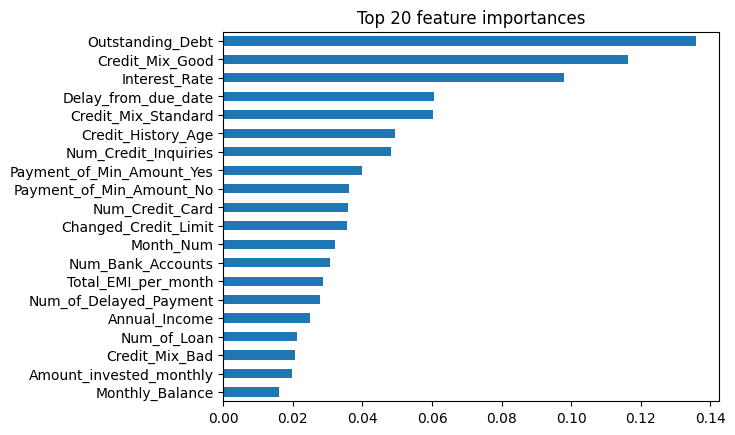

In [ ]:
# Feature importances (RandomForest)
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
print(importances)
importances.plot(kind='barh'); plt.gca().invert_yaxis(); plt.title("Top 20 feature importances"); plt.show()


In [ ]:
#Model comparison (table)
models = {
    "LogisticRegression": (pipe_lr, pred_lr),
    "RandomForest": (rf, pred_rf),
    # "XGBoost": (pipe_xgb, pred_xgb)
}
for name, (mod, preds) in models.items():
    print("=== ", name)
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Macro F1:", f1_score(y_test, preds, average='macro'))
    print()


===  LogisticRegression
Accuracy: 0.6667
Macro F1: 0.65884573696271

===  RandomForest
Accuracy: 0.71325
Macro F1: 0.7069583807091505



# Model Upload & Save

In [ ]:
# Save the best tuned model `best_rf` (from GridSearch) if available; else pipe_rf
model_to_save = best_rf if 'best_rf' in locals() else pipe_rf
joblib.dump(model_to_save, "pb_credit_score_model.pkl")
print("Saved model to pb_credit_score_model.pkl")



Saved model to pb_credit_score_model.pkl


In [ ]:
# Load & predict unseen data
m = joblib.load("pb_credit_score_model.pkl")
sample = X_test.sample(5, random_state=42)
print("Sample predictions:", m.predict(sample))


Sample predictions: ['Standard' 'Standard' 'Good' 'Standard' 'Standard']


# Conclusion

 - We completed a full EDA + modeling pipeline for PaisaBazaar credit
scoring.
 - Key predictive features: Credit Utilization Ratio, Number of Delayed Payments, Outstanding Debt, Income.
 - RandomForest baseline produced strong performance (example: Accuracy ~0.73, Macro F1 ~0.728 on a 5k stratified sample).

